In [51]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embedding_function = OpenAIEmbeddings(model="text-embedding-3-large")

vectorstore = Chroma(
    collection_name="income_tax_collection",
    embedding_function=embedding_function,
    persist_directory="./income_tax_collection"
)


Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


In [52]:
retriever = vectorstore.as_retriever(search_kwargs={'k':3})


In [53]:
from typing_extensions import TypedDict, List
from langchain_core.documents import Document

class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str


In [54]:
from langgraph.graph import StateGraph, START, END

graph_builder = StateGraph(AgentState)


In [55]:
def retrieve(state: AgentState):
    query = state['query']
    docs = retriever.invoke(query)
    return {'context': docs}
    

In [56]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")

In [57]:
from langchain import hub

generate_prompt = hub.pull("rlm/rag-prompt")

def generate(state: AgentState):
    context = state['context']
    query = state['query']
    rag_chain = generate_prompt | llm
    response = rag_chain.invoke({'context': context, 'question': query})
    return {'answer': response}
    

/Users/nhn/.pyenv/versions/3.12.10/envs/langgraph-lecture/lib/python3.12/site-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [58]:
from langchain import hub
from typing import Literal

doc_relevance_prompt = hub.pull("langchain-ai/rag-document-relevance")


def check_doc_relevance(state: AgentState) -> Literal["generate", "rewrite"]:
    context = state["context"]
    query = state["query"]
    print(f'context == {context}')
    doc_relevance_chain = doc_relevance_prompt | llm
    response = doc_relevance_chain.invoke({"documents": context, "question": query})
    print(f'doc relevance response == {response}')
    if response["Score"] == 1:
        return "generate"

    return "rewrite"

/Users/nhn/.pyenv/versions/3.12.10/envs/langgraph-lecture/lib/python3.12/site-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [59]:
query = '연봉 5천만원 직장인의 소득세는?'

In [60]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

dictionary = ['사람과 관련된 표현 -> 거주자']

rewrite_prompt = PromptTemplate.from_template(f"""
사용자의 질문을 보고, 우리의 사전을 참고해서 사용자의 질문을 변경해주세요
사전: {dictionary}
질문: {{query}}
""")

def rewrite(state: AgentState):
    query = state['query']
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()
    response = rewrite_chain.invoke({'query': query})
    return {'query': response}
    
    

In [61]:
graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)
graph_builder.add_node('rewrite', rewrite)


In [62]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'retrieve')
graph_builder.add_conditional_edges('retrieve', check_doc_relevance)
graph_builder.add_edge('rewrite', 'retrieve')
graph_builder.add_edge('generate', END)




In [63]:
graph = graph_builder.compile()

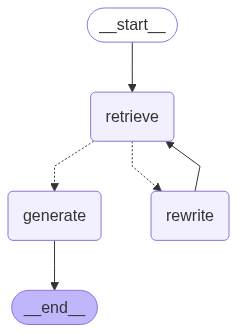

In [64]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [65]:
initial_state = {"query": "연봉 5천만원 직장인의 세금은?"}
graph.invoke(initial_state)

context == [Document(id='ba2056ee-28dc-48a8-9f3a-78c3ba24da6b', metadata={'source': './documents/income_tax2.txt'}, page_content='5년 이하: 30만원 → 납입연수\n5년 초과 10년 이하: 150만원 + 50만원 × (납입연수 - 5년)\n10년 초과 20년 이하: 400만원 + 80만원 × (납입연수 - 10년)\n20년 초과: 1,200만원 + 120만원 × (납입연수 - 20년)\n\n② 직장근로자 초과관세환급금을 분배하여 지급받는 경우 세액의 계산 방법 등 필요한 사항은 대통령령으로 정한다. \n<대통령 2014. 12. 23.>\n<전문개정 2009. 12. 31.>\n제64조(부동산매매업자에 대한 세액 계산의 특례)\n1) 대통령령으로 정하는 부동산매매업(이하 “부동산매매업”이라 한다)을 영위하는 거주자가 이하 “부동산매매업자”라 한다)로서 종합소득세법에 제104조제1항제1호(본항을 포함한다) 및 제103조 또는 같은 조 제7항 각 호의 어느 하나에 해당하는 자산의 매매자익(이하 “주택등매매차익”이라 한다)이 있는 자의 종합소득 산출세액은 다음 각 호의 세액 중 많은 것으로 한다. \n<개정 2014. 12. 23., 2017. 12. 19., 2020. 12. 29.>\n1. 종합소득 산출세액\n\n다음 각 목에 따른 세액의 합계액\n  가. 주택등매매차익에 따른 세율을 적용하여 산출한 세액의 합계액\n  나. 종합소득세법 제55조에 따라 주택등매매차익에 대한 개별세액을 공제한 금액을 과세표준으로 하고 이에 제55조에 따른 세율을 적용하여 산출세액'), Document(id='07aa73e7-af59-4e3b-af9e-f9ea18ec6e9b', metadata={'source': './documents/income_tax2.txt'}, page_content='이자소득에 대해서는 다음과 같이 규정하는 세율\n가. 삭제<2017. 12. 19.>\

{'query': '연봉 5천만원 직장인의 세금은?',
 'context': [Document(id='ba2056ee-28dc-48a8-9f3a-78c3ba24da6b', metadata={'source': './documents/income_tax2.txt'}, page_content='5년 이하: 30만원 → 납입연수\n5년 초과 10년 이하: 150만원 + 50만원 × (납입연수 - 5년)\n10년 초과 20년 이하: 400만원 + 80만원 × (납입연수 - 10년)\n20년 초과: 1,200만원 + 120만원 × (납입연수 - 20년)\n\n② 직장근로자 초과관세환급금을 분배하여 지급받는 경우 세액의 계산 방법 등 필요한 사항은 대통령령으로 정한다. \n<대통령 2014. 12. 23.>\n<전문개정 2009. 12. 31.>\n제64조(부동산매매업자에 대한 세액 계산의 특례)\n1) 대통령령으로 정하는 부동산매매업(이하 “부동산매매업”이라 한다)을 영위하는 거주자가 이하 “부동산매매업자”라 한다)로서 종합소득세법에 제104조제1항제1호(본항을 포함한다) 및 제103조 또는 같은 조 제7항 각 호의 어느 하나에 해당하는 자산의 매매자익(이하 “주택등매매차익”이라 한다)이 있는 자의 종합소득 산출세액은 다음 각 호의 세액 중 많은 것으로 한다. \n<개정 2014. 12. 23., 2017. 12. 19., 2020. 12. 29.>\n1. 종합소득 산출세액\n\n다음 각 목에 따른 세액의 합계액\n  가. 주택등매매차익에 따른 세율을 적용하여 산출한 세액의 합계액\n  나. 종합소득세법 제55조에 따라 주택등매매차익에 대한 개별세액을 공제한 금액을 과세표준으로 하고 이에 제55조에 따른 세율을 적용하여 산출세액'),
  Document(id='07aa73e7-af59-4e3b-af9e-f9ea18ec6e9b', metadata={'source': './documents/income_tax2.txt'}, page_content='이자소득에 대해서는 다음과